In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as stats_graph_tsa
import statsmodels.tsa.stattools as stat_tsa_stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas_datareader import data as wb
from scipy.stats.distributions import chi2
from datetime import datetime

sns.set()

In [2]:
raw_csv_data = pd.read_csv('../01 - Intro/IndexE8.csv')
df_complete = raw_csv_data.copy()

df_complete['market_value'] = df_complete.spx

# Transform Date column to the type Date
df_complete.date = pd.to_datetime(df_complete.date, dayfirst = True)

# Setting Date as Index
df_complete.date = df_complete.set_index('date', inplace = True)

# Setting Frequency as Business Day
df_complete = df_complete.asfreq('b')

# Fill empty values -> Front Fill
df_complete = df_complete.fillna(method = 'ffill')

del df_complete['dax']
del df_complete['ftse']
del df_complete['nikkei']
del df_complete['spx']

# Getting 80% of the Data Set
size = int(len(df_complete) * 0.8)

# Setting Train and Test
df, df_test = df_complete.iloc[:size], df_complete.iloc[size:]

In [3]:
def LLR_Test (mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf

    LR = (2 * (L2 - L1))
    pvalue = chi2.sf(LR, DF).round(4)

    return pvalue

**Normalized Returns**

In [4]:
'''
    Normalized Returns -> They account for the absolute profitability of the investment in contrast
                          to prices, allowing to compare the relative profitability as opposed to
                          non-normalized returns.
'''
''' Defining the return column '''
df['returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]

benchmark_ret = df.returns.iloc[0]
df['norm_ret'] = df.returns.div(benchmark_ret).mul(100)

# Significally less statistical value and more P Value in this case, meaning that this set
# is probably stationary
stat_tsa_stats.adfuller(df.norm_ret)

C:\Users\Yago\AppData\Local\Temp\ipykernel_14436\1317757927.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns'] = df.market_value.pct_change(1).mul(100)


(-17.03445719098116,
 8.28053702031718e-30,
 17,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 60636.5822032878)

In [5]:
mod_ar_7 = ARIMA(df.market_value, order = (7, 0, 0))
res_ar_7 = mod_ar_7.fit()
# Best choice of model is 6, previous analysed
mod_ret_ar = ARIMA(df.returns, order = (6, 0, 0))
res_ret_ar = mod_ret_ar.fit()
mod_norm_ret_ar = ARIMA(df.norm_ret, order = (6, 0, 0))
res_norm_ret_ar = mod_norm_ret_ar.fit()

![title](../public/residual.png)
**1.)** We are going to extract the Residuals of the Models that we believe to be good.
**2.)** Examine a summary of their statistics
**3.)** Testing them for Stationarity
**4.)** Apply the DF-Test(DickFuller Test) before plotting the values

**----------------------------Analysing Residuals of Prices-----------------------------------------------------------------------------------------**

In [6]:
df['res_price'] = res_ar_7.resid

# The mean is close to 0 which suggest that on average our model performs well
print(f'Mean: {df.res_price.mean()}')
# The High Variance indicates that the Residuals are not concentrated around the mean of 0, but all over the place
# That simply because AR Models perform poorly when predicting NoN-Stationarity Data
print(f'Variance: {df.res_price.var()}')
print(f'DF Test: {stat_tsa_stats.adfuller(df.res_price)}')

Mean: 0.1329085592938301
Variance: 249.5661503518898
DF Test: (-16.073007479853104, 5.481003381124499e-29, 17, 5002, {'1%': -3.431658008603046, '5%': -2.862117998412982, '10%': -2.567077669247375}, 39895.73547825188)


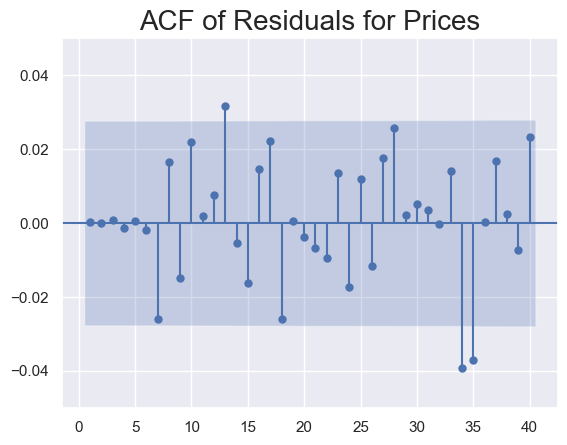

In [7]:
stats_graph_tsa.plot_acf(df.res_price, zero = False, lags = 40)
plt.title('ACF of Residuals for Prices', size = 20)
plt.ylim([-0.05,0.05])
plt.show()

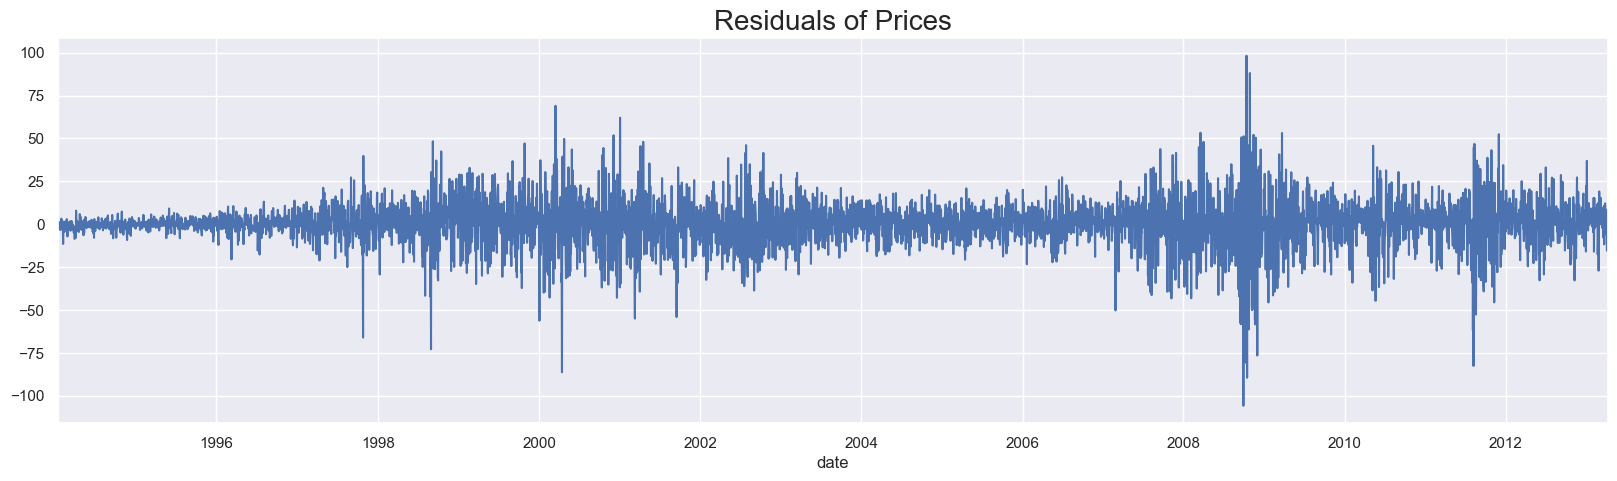

In [8]:
df.res_price[1:].plot(figsize = (20, 5))
plt.title("Residuals of Prices", size = 20)
plt.show()

**----------------------------Analysing Residuals of Return-----------------------------------------------------------------------------------------**

In [9]:
df['res_ret_ar'] = res_ret_ar.resid

df.res_ret_ar.mean()
df.res_ret_ar.var()

print(f'Mean: {df.res_price.mean()}')
print(f'Variance: {df.res_price.var()}')

Mean: 0.1329085592938301
Variance: 249.5661503518898


In [10]:
stat_tsa_stats.adfuller(df.res_ret_ar)

(-16.700354095879153,
 1.463011896081126e-29,
 17,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 16035.856603395878)

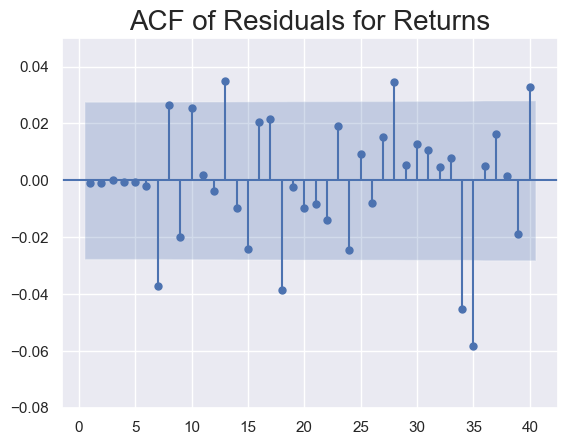

In [11]:
stats_graph_tsa.plot_acf(df.res_ret_ar, zero = False, lags = 40)
plt.title('ACF of Residuals for Returns', size = 20)
plt.ylim([-0.08,0.05])
plt.show()

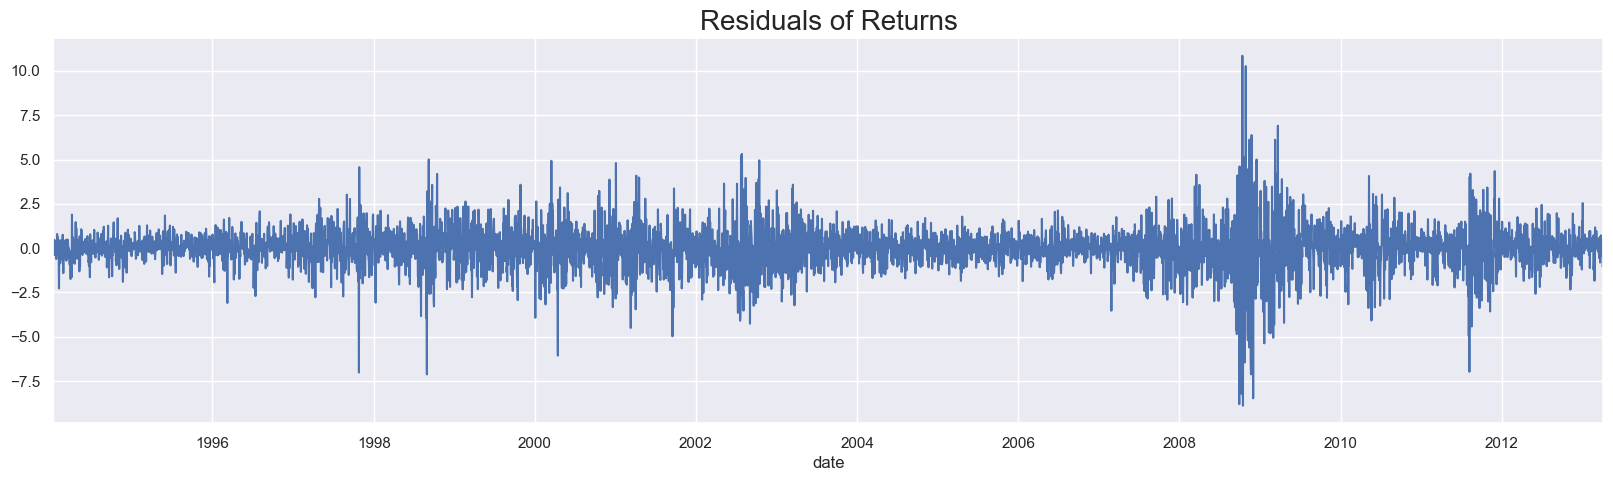

In [13]:
df.res_ret_ar[1:].plot(figsize = (20, 5))
plt.title("Residuals of Returns", size = 20)
plt.show()